In [1]:
%matplotlib widget
%reload_ext autoreload

%autoreload 2
    
import os, glob, datetime, csv
from functools import partial
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tokenizers import Tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import sentiment_analysis
from sentiment_analysis import SentimentDataset, CustomTransformerModel, collate_fn

In [3]:
file = glob.glob("data/*.csv")[0]
df = pd.read_csv(file, index_col=0).dropna(how="any", axis=0)

### Build tokenizer

In [7]:
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

text = df["statement"].tolist()

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(vocab_size=30000, min_frequency=3, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.pre_tokenizer = Whitespace()

tokenizer.train_from_iterator(text, trainer)

tokenizer.save("data/tokenizer-mental-health.json")

### Modeling

#### Eval tokenizer

In [4]:
tokenizer = Tokenizer.from_file("data/tokenizer-mental-health.json")

In [5]:
tokenizer.encode("on my gosh").tokens

['on', 'my', 'gosh']

#### Augument data to make data balance

In [6]:
df.groupby("status").count()

,statement
status,
Anxiety,3841
Bipolar,2777
Depression,15404
Normal,16343
Personality disorder,1077
Stress,2587
Suicidal,10652


In [7]:
threshold = df.groupby("status").count().quantile(0.7)

threshold.values[0]

for status in df["status"].unique():
    _data = df[df["status"] == status]
    if len(_data) < threshold.values[0]:
        print(f"{status}, {len(_data)}")
        n = threshold.values[0] // len(_data)
        for _ in range(int(n)):
            df = pd.concat((df, _data))

Anxiety, 3841
Suicidal, 10652
Stress, 2587
Bipolar, 2777
Personality disorder, 1077


In [8]:
df.groupby("status").count()

,statement
status,
Anxiety,15364
Bipolar,13885
Depression,15404
Normal,16343
Personality disorder,11847
Stress,12935
Suicidal,21304


#### Build datasets

In [9]:
DROPOUT = 0.2
BATCH_SIZE = 64
D_MODEL = 16
FF_SIZE = 8
EPOCH = 20

In [10]:
max_length = int(df["statement"].apply(len).quantile(0.9))
max_length = 1562

statements = df["statement"].values
labels = df["status"].values

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

train_statements, val_statements, train_labels, val_labels = train_test_split(statements, encoded_labels, test_size=0.2, random_state=42)

In [11]:
def tokenization(text):
    return tokenizer.encode(text).ids

# Create datasets
train_dataset = SentimentDataset(train_statements, train_labels, tokenizer=tokenization)
val_dataset = SentimentDataset(val_statements, val_labels, tokenizer=tokenization)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

In [12]:
# Instantiate the model
vocab_size = 30000  # Based on simple_tokenizer, you may need to adjust this based on your tokenizer
model = CustomTransformerModel(vocab_size=vocab_size, 
                               d_model=16, 
                               max_length=max_length,
                               nhead=2, 
                               num_encoder_layers=4, 
                               num_classes=len(label_encoder.classes_), 
                               dropout=DROPOUT, 
                               dim_feedforward=FF_SIZE).to(device)

### Model training loop

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-8)

# Training loop
num_epochs = EPOCH
model.train()

write = open("epoches.csv", "w")
writer = csv.writer(write)
writer.writerow([f"Dropout: {DROPOUT}, Batch_size: {BATCH_SIZE}, D_model: {D_MODEL}, Feed forward: {FF_SIZE}"])

try:
    for epoch in range(num_epochs):
        print(f"{datetime.datetime.now().strftime('%H:%M:%S %p')}: start training epoch {epoch+1}...")
        total_losses = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_losses += loss.item()                
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        training_loss = total_losses/len(train_loader)
        train_accuracy = 100 * correct / total
              
        # Optional: Evaluate on the validation set after each epoch
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)        
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}, Training loss: {training_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%; Validation Loss: {val_loss/len(val_loader):.6f}, Accuracy: {100 * correct / total:.2f}%, Learning rate: {scheduler.get_last_lr()[0]}')
        writer.writerow([f'Epoch {epoch+1}, Training loss: {training_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%; Validation Loss: {val_loss/len(val_loader):.6f}, Accuracy: {100 * correct / total:.2f}%, Learning rate: {scheduler.get_last_lr()[0]}'])
        model.train()
except KeyboardInterrupt as e:
    raise e
finally:
    write.close()
    torch.save(model.state_dict(), "model_state.pth")

16:10:52 PM: start training epoch 1...
Epoch 1, Training loss: 1.307460, Train Accuracy: 47.21%; Validation Loss: 0.976432, Accuracy: 61.42%, Learning rate: 0.001
16:11:44 PM: start training epoch 2...
Epoch 2, Training loss: 0.797408, Train Accuracy: 70.13%; Validation Loss: 0.660837, Accuracy: 75.89%, Learning rate: 0.001
16:12:37 PM: start training epoch 3...
Epoch 3, Training loss: 0.568913, Train Accuracy: 79.12%; Validation Loss: 0.540600, Accuracy: 80.47%, Learning rate: 0.001
16:13:29 PM: start training epoch 4...
Epoch 4, Training loss: 0.449160, Train Accuracy: 83.37%; Validation Loss: 0.474393, Accuracy: 82.87%, Learning rate: 0.001
16:14:22 PM: start training epoch 5...
Epoch 5, Training loss: 0.369433, Train Accuracy: 86.26%; Validation Loss: 0.400539, Accuracy: 85.61%, Learning rate: 0.001
16:15:15 PM: start training epoch 6...
Epoch 6, Training loss: 0.316255, Train Accuracy: 88.08%; Validation Loss: 0.378805, Accuracy: 86.23%, Learning rate: 0.001
16:16:09 PM: start tra

### Model Evaluation

In [14]:
model_state_dict = torch.load("model_state.pth", weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [15]:
model.eval()

CustomTransformerModel(
  (embedding): Embedding(30000, 16)
  (positional_embedding): Embedding(1562, 16)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=8, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=8, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=16, out_features=7, bias=True)
)

In [ ]:
# model.to("cpu")

In [77]:
input_statement = """The model performed well, but can be improved on classes of 'Normal' and 'Depression'. 
With the original dataset without any augumentation, it can only reach 74% accuracy, but with augumentation to balance each class, it eventually reached 90% accuracy.
Funny though the model thinks this statement is 'Stress'."""

tokens = tokenizer.encode(input_statement)
res = model(torch.tensor(tokens.ids).view(1, -1).to(device))
_, label = torch.max(res, 1)
result = label_encoder.inverse_transform(label.to("cpu"))[0]
print(result)

Stress


#### Evaluation model performance

In [17]:
df = pd.read_csv(file, index_col=0).dropna(how="any", axis=0)
statements = df["statement"].values
labels = df["status"].values

whole_dataset = SentimentDataset(statements, label_encoder.transform(labels), tokenizer=tokenization)
whole_loader = DataLoader(whole_dataset, batch_size=32, collate_fn=collate_fn)


from tqdm.auto import tqdm

predicted_res = []
correct, total = 0, 0
with torch.no_grad():
    for item, label_ in tqdm(whole_loader):
        item = item.to(device)
        label_ = label_.to(device)
        outputs = model(item)
        _, predicted = torch.max(outputs, 1)
        total += label_.size(0)
        correct += (predicted == label_).sum().item()
        predicted_res += [predicted]

accuracy = correct / total * 100

predicted_res = torch.cat(predicted_res)

print(f"Accuracy: {accuracy:.2f}%")

  0%|          | 0/1647 [00:00<?, ?it/s]

Accuracy: 90.73%


In [40]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = whole_dataset.labels, predicted_res.to("cpu").numpy()

In [19]:
f1_score(y_true, y_pred, average="weighted")

0.907582782592351

In [20]:
recall_score(y_true, y_pred, average="weighted")

0.9072720715248381

In [21]:
r = {}

for ground_truth, predicted_label in zip(y_true, y_pred):
    r[ground_truth] = r.get(ground_truth, []) + [predicted_label]

In [61]:
for key, values in r.items():
    score = f1_score(np.asarray([key]*len(values)), np.asarray(values), average="micro")
    precission = precision_score(np.asarray([key]*len(values)), np.asarray(values), average="micro")
    print(f"""{label_encoder.inverse_transform(np.array([key]))[0]}: f1_score: {score}, precission score: {precission}""")

Anxiety: f1_score: 0.9955740692527988, precission score: 0.9955740692527988
Normal: f1_score: 0.8880254543229518, precission score: 0.8880254543229518
Depression: f1_score: 0.8284861075045443, precission score: 0.8284861075045443
Suicidal: f1_score: 0.963762673676305, precission score: 0.963762673676305
Stress: f1_score: 0.9976807112485504, precission score: 0.9976807112485504
Bipolar: f1_score: 0.9985595966870724, precission score: 0.9985595966870724
Personality disorder: f1_score: 1.0, precission score: 1.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
cm = confusion_matrix(y_true, y_pred)

In [46]:
labels_display = label_encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6])

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=labels_display)

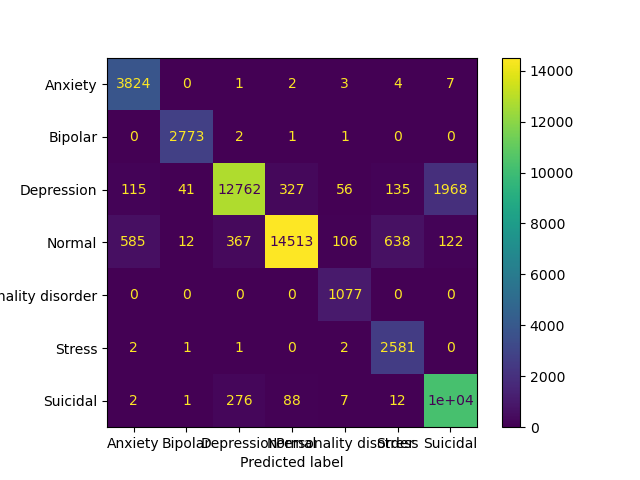

In [58]:
disp.plot()

In [59]:
plt.tight_layout()

In [78]:
plt.savefig("confusion_matrix.png")